# Capstone project 1: Housing prices advanced regression



In [5]:
#-----------------------------------------------------------------------------#
import pandas as pd
import numpy

#Load training data from csv files
df = pd.read_csv('train.csv', index_col=['Id']) 


In [6]:
#get overall information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

### The following fields don't have enough non-null data, therefore, it's better to drop it.
#### Alley            91 non-null object 
#### PoolQC           7 non-null object 
#### Fence            281 non-null object 
#### MiscFeature      54 non-null object 



In [7]:
df = df.drop(columns=['Alley','PoolQC','Fence','MiscFeature'])

In [8]:
#deal with NaN 
#for catergorial data, fill them with 'MS',meaning Missing
#for numeric data, fill with 0
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_string_dtype

flag=1
for col in df.columns: #Check whether 'MS' is already a value in data frame
    if 'MS' in df[col].values:
        print(col)
        flag=0
    
if flag:
    print('MS '+'is not present as a value in data')

for col in df.columns:
    if is_numeric_dtype(df[col]):
        df[col]=df[col].fillna(0) #fill na with 0
    else:
        df[col]=df[col].fillna('MS') #fill na with MS

# change to category

for col in df.columns: #these columns are string type, so they are catergorial
    if is_string_dtype(df[col]):
        df[col] = df[col].astype('category')
for col in ['MSSubClass','OverallQual','OverallCond']:#these columns are integers, but still is catergorial
    df[col] = df[col].astype('category')
df.info()

MS is not present as a value in data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 76 columns):
MSSubClass       1460 non-null category
MSZoning         1460 non-null category
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null category
LotShape         1460 non-null category
LandContour      1460 non-null category
Utilities        1460 non-null category
LotConfig        1460 non-null category
LandSlope        1460 non-null category
Neighborhood     1460 non-null category
Condition1       1460 non-null category
Condition2       1460 non-null category
BldgType         1460 non-null category
HouseStyle       1460 non-null category
OverallQual      1460 non-null category
OverallCond      1460 non-null category
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null category
RoofMatl         1460 non-null category
Exterior1st      1460 non-

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [9]:
#change the year to age
for col in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
    df[col] = df['YrSold'] - df[col]
#change SalePrice to fold of 10000
df['SalePrice'] = df.SalePrice / 10000

In [10]:
#data visualization for data exploration
import matplotlib.pyplot as plt
import seaborn as sns

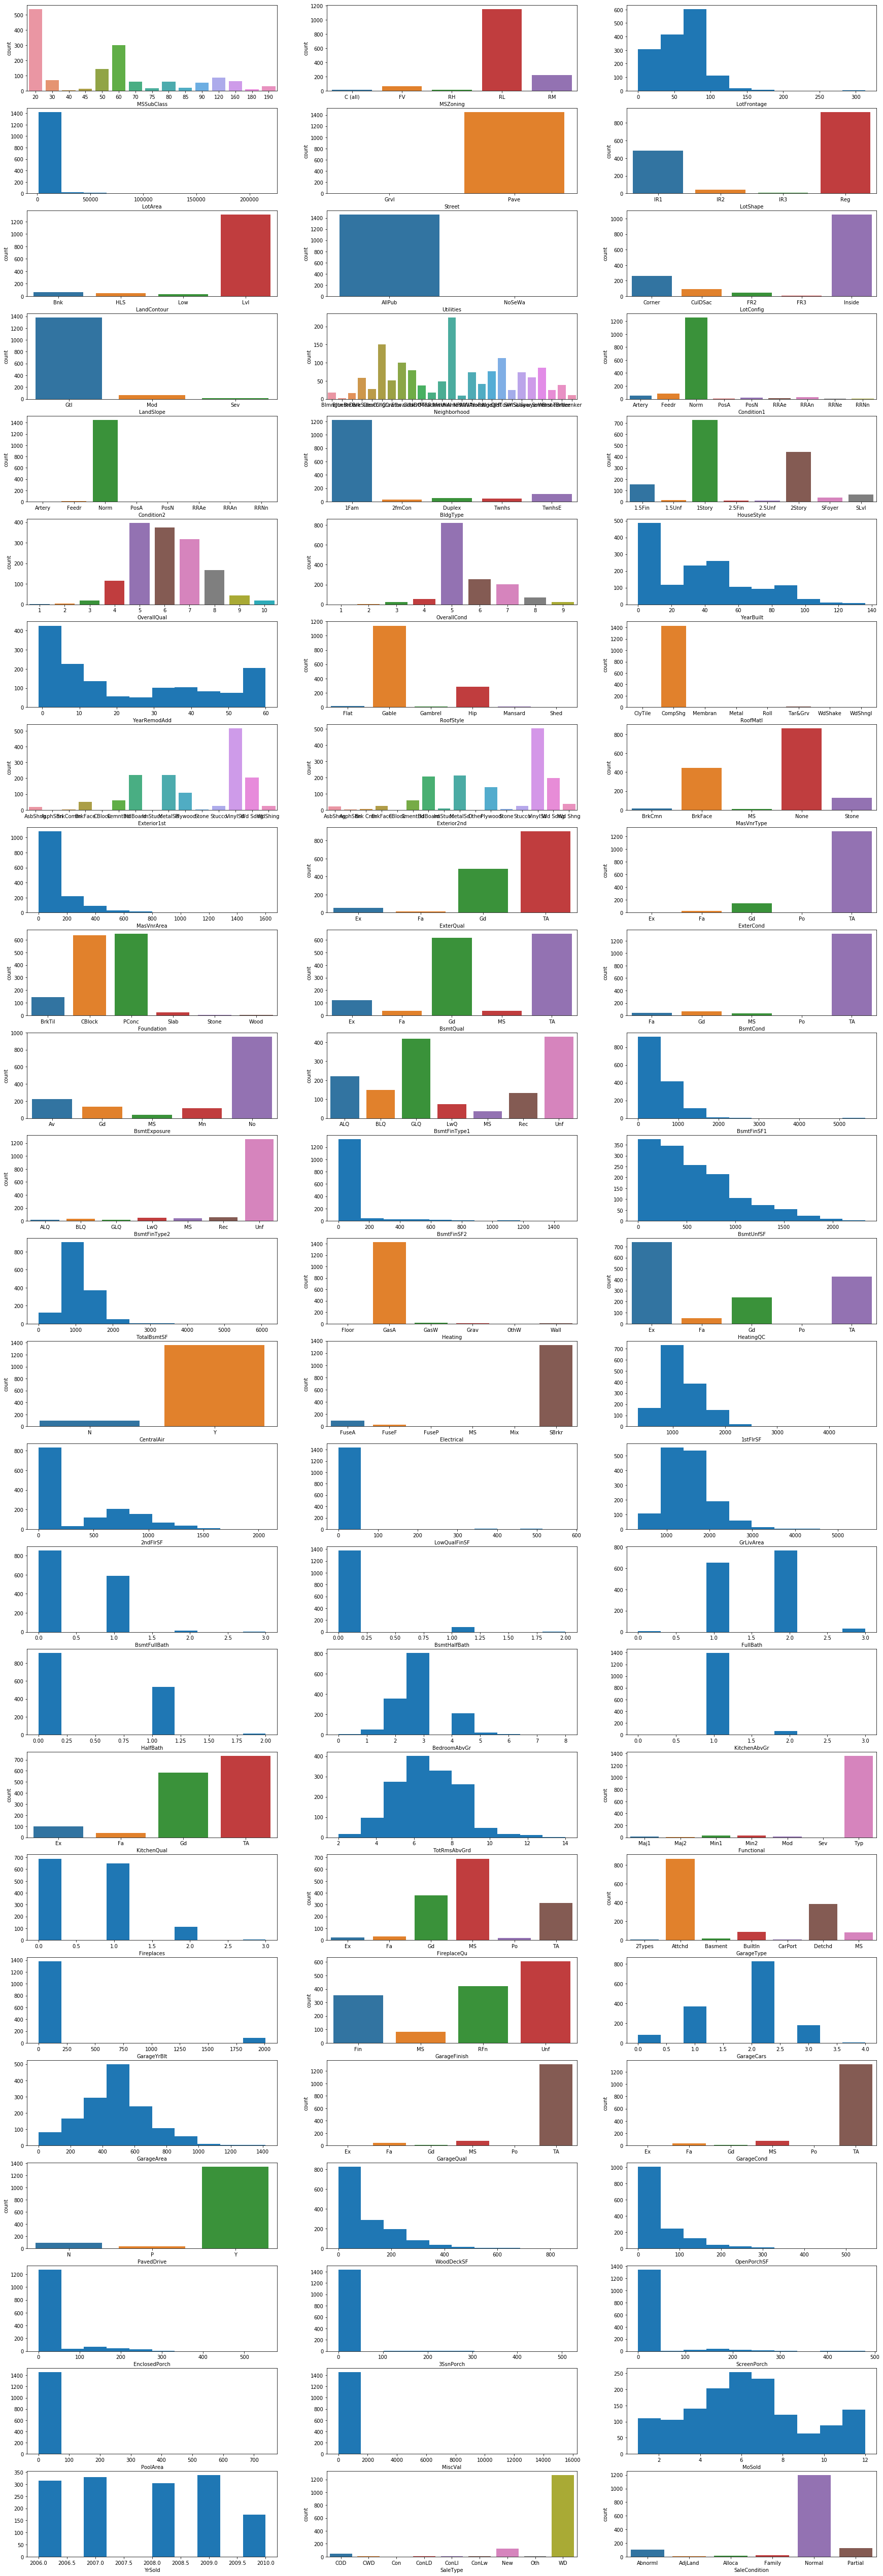

In [11]:
#Plot distribution of each column
fig1 = plt.figure(figsize=(30,100))
y_col = df.columns[-1]
a = 1 #active plot number
for col in df.columns[:-1]:
    ax = fig1.add_subplot(27,3,a)
    if is_string_dtype(df[col]):
        sns.countplot(data=df, x=col,ax=ax)
    else:
        ax.hist(df[col], bins=10)
    ax.set_xlabel(col)
    a += 1
    
fig1.savefig('distribution_plot.png')


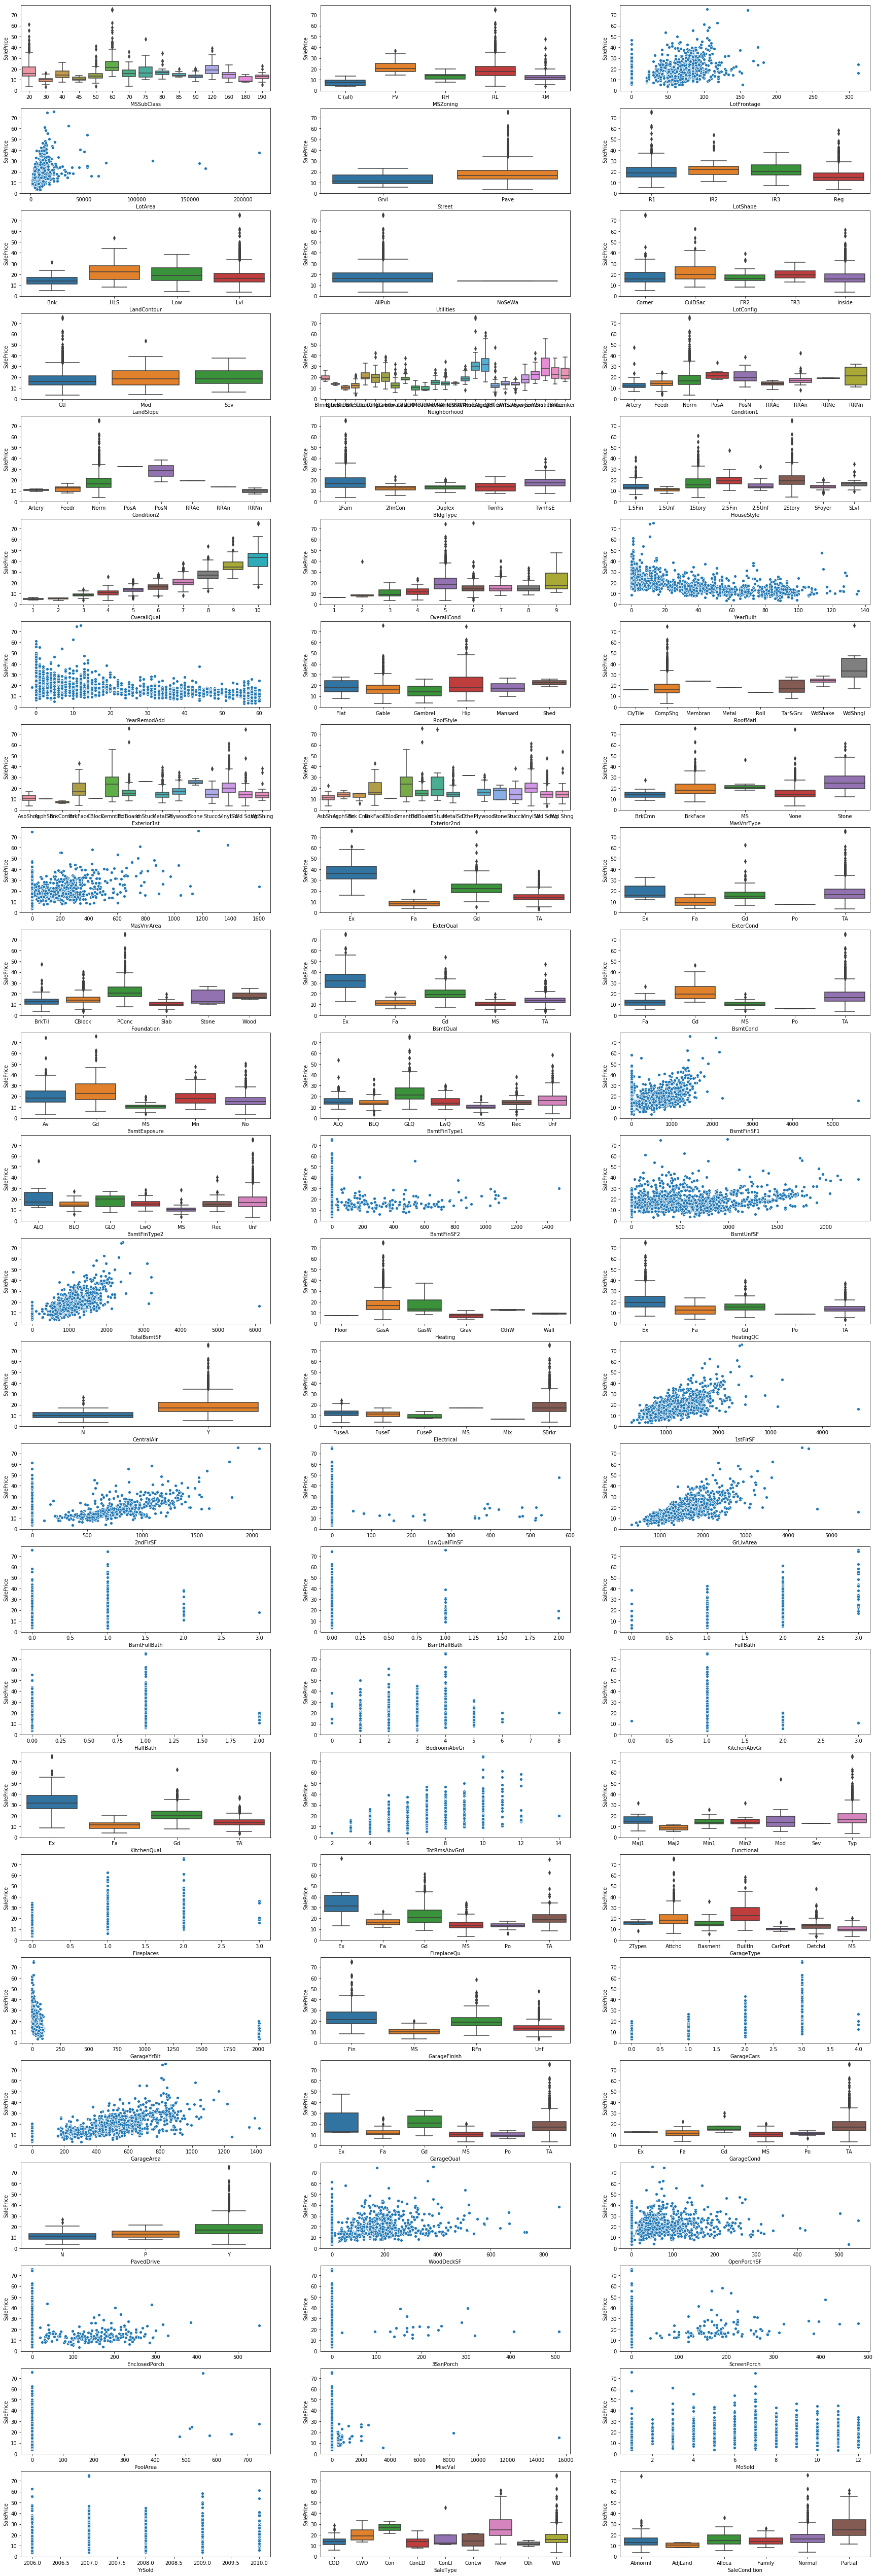

In [13]:
#plot coloumn and SalePrice relation
fig2 = plt.figure(figsize=(30,100))

a = 0 #active plot number
for col in df.columns[:-1]:
    a += 1
    ax = fig2.add_subplot(27,3,a)
    if is_string_dtype(df[col]):
        sns.catplot(x=col, y=y_col,kind='box',data=df,ax=ax)
        
    else:
        sns.scatterplot(x=col, y=y_col, data=df,ax=ax)
    
    ax.set_xlabel(col)
    plt.close(2)
    
fig2.savefig('Correlation_plot.png')

# Modeling
## First Model: polynomial regression

In [19]:
#Drop duplicates
df = df.drop_duplicates()
df.shape        

(1460, 76)

In [20]:
import json